# **Active learning comparison between the two models**

## **Preliminary steps**

In [1]:
### PACKAGES

import copy
import torch

In [2]:
### FUNCTIONS AND CLASSES

from src.libs import preprocessing, visualization, utils, active_learning
from src.libs.tokenizer import ReversedPairingTokenizer
from src.model.transformer import MyTransformer

In [3]:
### DEVICE

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")

Using device: cpu


## **Tokenizer**

In [4]:
### CREATE TOKENIZER

tokenizer = ReversedPairingTokenizer()
VOCAB_SIZE = tokenizer.ntokens
print(f"Vocabulary size: {VOCAB_SIZE}")

Vocabulary size: 114


## **Data**

In [5]:
### CONSTANTS

NUM_DIGITS = 3

TRAIN_SIZE = 500
VALID_SIZE = 100
TEST_SIZE = 1000
POOL_SIZE = 1000

In [6]:
### CREATE DATASETS

train_dataset = preprocessing.create_dataset(
    nb_samples=TRAIN_SIZE, num_digits=NUM_DIGITS
)

valid_dataset = preprocessing.create_dataset(
    nb_samples=VALID_SIZE, num_digits=NUM_DIGITS
)

test_dataset = preprocessing.create_dataset(nb_samples=TEST_SIZE, num_digits=NUM_DIGITS)

pool_dataset = preprocessing.create_dataset(nb_samples=POOL_SIZE, num_digits=NUM_DIGITS)

## **MODELS**

In [7]:
### ARCHITECTURE

NB_LAYERS = 2
NB_HEADS = 8
EMBEDDING_DIMENSION = 64
HEAD_SIZE = 8  # EMBEDDING_DIMENSION // NB_HEADS
CONTEXT_LENGTH = 20
HIDDEN_DIMENSION = 8
DROPOUT_TRANSFORMER = 0.1
DROPOUT_BAYESFORMER = 0.3

In [8]:
### TRANSFORMER

transformer = MyTransformer(
    ntoken=VOCAB_SIZE,
    d_model=EMBEDDING_DIMENSION,
    n_heads=NB_HEADS,
    dim_feedforward=HIDDEN_DIMENSION,
    nlayers=NB_LAYERS,
    dropout=DROPOUT_TRANSFORMER,
).to(DEVICE)

print(
    "number of parameters: {}".format(
        sum([x.numel() for x in transformer.parameters()])
    )
)

number of parameters: 50178


In [9]:
### BAYESFORMER

bayesformer = MyTransformer(
    ntoken=VOCAB_SIZE,
    d_model=EMBEDDING_DIMENSION,
    n_heads=NB_HEADS,
    dim_feedforward=HIDDEN_DIMENSION,
    nlayers=NB_LAYERS,
    bayes_dropout=DROPOUT_BAYESFORMER,
    bayes=True,
).to(DEVICE)

print(
    "number of parameters: {}".format(
        sum([x.numel() for x in bayesformer.parameters()])
    )
)

number of parameters: 50178


## **TRAINING**

In [10]:
### CONSTANTS

NB_EPOCHS = 80
BATCH_SIZE = 20
LEARNING_RATE = 1e-3

assert (
    TRAIN_SIZE % BATCH_SIZE == 0
    and VALID_SIZE % BATCH_SIZE == 0
    and TEST_SIZE % BATCH_SIZE == 0
), "BATCH_SIZE must be a divisor of TRAIN_SIZE, VALID_SIZE and TEST_SIZE"

In [11]:
### TRAIN TRANSFORMER

train_losses_transformer, valid_losses_transformer = utils.train(
    model=transformer,
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    nb_epochs=NB_EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LEARNING_RATE,
    vocab_size=VOCAB_SIZE,
    tokenizer=tokenizer,
    device=DEVICE,
)

EPOCH [8 / 80] ----------- TRAIN LOSS : 0.0744, VALID LOSS : 0.073250
EPOCH [16 / 80] ----------- TRAIN LOSS : 0.0555, VALID LOSS : 0.057288
EPOCH [24 / 80] ----------- TRAIN LOSS : 0.0313, VALID LOSS : 0.044508
EPOCH [32 / 80] ----------- TRAIN LOSS : 0.0193, VALID LOSS : 0.039214
EPOCH [40 / 80] ----------- TRAIN LOSS : 0.0132, VALID LOSS : 0.035574
EPOCH [48 / 80] ----------- TRAIN LOSS : 0.0094, VALID LOSS : 0.038091
EPOCH [56 / 80] ----------- TRAIN LOSS : 0.0069, VALID LOSS : 0.036905
EPOCH [64 / 80] ----------- TRAIN LOSS : 0.0054, VALID LOSS : 0.037626
EPOCH [72 / 80] ----------- TRAIN LOSS : 0.0044, VALID LOSS : 0.034891
EPOCH [80 / 80] ----------- TRAIN LOSS : 0.0032, VALID LOSS : 0.037323
Best valid loss : 0.0341


In [12]:
### TRAIN BAYESFORMER

train_losses_bayesformer, valid_losses_bayesformer = utils.train(
    model=bayesformer,
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    nb_epochs=NB_EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LEARNING_RATE,
    vocab_size=VOCAB_SIZE,
    tokenizer=tokenizer,
    device=DEVICE,
)

EPOCH [8 / 80] ----------- TRAIN LOSS : 0.0854, VALID LOSS : 0.082376
EPOCH [16 / 80] ----------- TRAIN LOSS : 0.0744, VALID LOSS : 0.073735
EPOCH [24 / 80] ----------- TRAIN LOSS : 0.0672, VALID LOSS : 0.066824
EPOCH [32 / 80] ----------- TRAIN LOSS : 0.0576, VALID LOSS : 0.059008
EPOCH [40 / 80] ----------- TRAIN LOSS : 0.0497, VALID LOSS : 0.050638
EPOCH [48 / 80] ----------- TRAIN LOSS : 0.0421, VALID LOSS : 0.042353
EPOCH [56 / 80] ----------- TRAIN LOSS : 0.0376, VALID LOSS : 0.041048
EPOCH [64 / 80] ----------- TRAIN LOSS : 0.0350, VALID LOSS : 0.037606
EPOCH [72 / 80] ----------- TRAIN LOSS : 0.0305, VALID LOSS : 0.033848
EPOCH [80 / 80] ----------- TRAIN LOSS : 0.0272, VALID LOSS : 0.030854
Best valid loss : 0.0302


## **Evaluation**

In [13]:
### EVALUATE TRANSFORMER

accuracy_test_transformer = utils.evaluate(
    model=transformer,
    dataset=test_dataset,
    tokenizer=tokenizer,
    batch_size=BATCH_SIZE,
    device=DEVICE,
)
print(f"Transformer accuracy on test set: {accuracy_test_transformer:.2f}")

### EXAMPLES

transformer.eval()

for i in range(5):
    prompt, answers = test_dataset[i]
    prompt_tensor = torch.tensor(tokenizer.encode(prompt)).view((-1, 1))
    output = utils.generate(transformer, prompt_tensor, len(answers) + 1, DEVICE).view(
        (1, -1)
    )
    print(tokenizer.decode(output.tolist()[0]) + "\t actual result: " + answers)

Transformer accuracy on test set: 0.35
440+420=680<EOS>	 actual result: 860
565+257=722<EOS>	 actual result: 822
937+623=1560<EOS>	 actual result: 1560
280+240=430<EOS>	 actual result: 520
550+89=749<EOS>	 actual result: 639


In [14]:
### EVALUATE BAYESFORMER

accuracy_test_bayesformer = utils.evaluate(
    model=bayesformer,
    dataset=test_dataset,
    tokenizer=tokenizer,
    batch_size=BATCH_SIZE,
    device=DEVICE,
)
print(f"Bayesformer accuracy on test set: {accuracy_test_bayesformer:.2f}")

### EXAMPLES

bayesformer.eval()

for i in range(5):
    prompt, answers = test_dataset[i]
    prompt_tensor = torch.tensor(tokenizer.encode(prompt)).view((-1, 1))
    output = utils.generate(bayesformer, prompt_tensor, len(answers) + 1, DEVICE).view(
        (1, -1)
    )
    print(tokenizer.decode(output.tolist()[0]) + "\t actual result: " + answers)

Bayesformer accuracy on test set: 0.19
440+420=870<EOS>	 actual result: 860
565+257=822<EOS>	 actual result: 822
937+623=1660<EOS>	 actual result: 1560
280+240=1300	 actual result: 520
550+89=549<EOS>	 actual result: 639


## **Active learning**

In [15]:
### CONSTANTS

AL_NB_EPOCHS = 50
AL_BATCH_SIZE = 20
AL_LEARNING_RATE = 1e-3

### Active learning with max uncertainty

In [16]:
max_greedy_transformer = copy.deepcopy(transformer)
max_sampling_transformer = copy.deepcopy(transformer)
max_dropout_bayesformer = copy.deepcopy(bayesformer)

In [17]:
### ACTIVE LEARNING WITH MAX UNCERTAINTY : GREEDY TRANSFORMER

ids_max_greedy_transformer = active_learning.select_samples(
    model=max_greedy_transformer,
    tokenizer=tokenizer,
    pool_dataset=pool_dataset,
    device=DEVICE,
    nb_samples=200,
    compute="greedy",
    mode="max",
)
max_greedy_train_dataset = active_learning.create_new_train_set(
    train_dataset=train_dataset,
    pool_dataset=pool_dataset,
    indices=ids_max_greedy_transformer,
)

max_greedy_train_losses_transformer, max_greedy_valid_losses_transformer = utils.train(
    model=max_greedy_transformer,
    train_dataset=max_greedy_train_dataset,
    valid_dataset=valid_dataset,
    nb_epochs=AL_NB_EPOCHS,
    batch_size=AL_BATCH_SIZE,
    lr=AL_LEARNING_RATE,
    vocab_size=VOCAB_SIZE,
    tokenizer=tokenizer,
    device=DEVICE,
)

EPOCH [5 / 50] ----------- TRAIN LOSS : 0.0062, VALID LOSS : 0.028321
EPOCH [10 / 50] ----------- TRAIN LOSS : 0.0042, VALID LOSS : 0.027096
EPOCH [15 / 50] ----------- TRAIN LOSS : 0.0038, VALID LOSS : 0.029228
EPOCH [20 / 50] ----------- TRAIN LOSS : 0.0030, VALID LOSS : 0.026758
EPOCH [25 / 50] ----------- TRAIN LOSS : 0.0033, VALID LOSS : 0.026846
EPOCH [30 / 50] ----------- TRAIN LOSS : 0.0025, VALID LOSS : 0.029989
EPOCH [35 / 50] ----------- TRAIN LOSS : 0.0022, VALID LOSS : 0.028597
EPOCH [40 / 50] ----------- TRAIN LOSS : 0.0022, VALID LOSS : 0.025512
EPOCH [45 / 50] ----------- TRAIN LOSS : 0.0027, VALID LOSS : 0.027571
EPOCH [50 / 50] ----------- TRAIN LOSS : 0.0015, VALID LOSS : 0.030367
Best valid loss : 0.0238


In [18]:
### ACTIVE LEARNING WITH MAX UNCERTAINTY : SAMPLING TRANSFORMER

ids_max_sampling_transformer = active_learning.select_samples(
    model=max_sampling_transformer,
    tokenizer=tokenizer,
    pool_dataset=pool_dataset,
    device=DEVICE,
    nb_samples=200,
    compute="sampling",
    mode="max",
)
max_sampling_train_dataset = active_learning.create_new_train_set(
    train_dataset=train_dataset,
    pool_dataset=pool_dataset,
    indices=ids_max_sampling_transformer,
)

max_sampling_train_losses_transformer, max_sampling_valid_losses_transformer = (
    utils.train(
        model=max_sampling_transformer,
        train_dataset=max_sampling_train_dataset,
        valid_dataset=valid_dataset,
        nb_epochs=AL_NB_EPOCHS,
        batch_size=AL_BATCH_SIZE,
        lr=AL_LEARNING_RATE,
        vocab_size=VOCAB_SIZE,
        tokenizer=tokenizer,
        device=DEVICE,
    )
)

EPOCH [5 / 50] ----------- TRAIN LOSS : 0.0053, VALID LOSS : 0.030503
EPOCH [10 / 50] ----------- TRAIN LOSS : 0.0045, VALID LOSS : 0.028638
EPOCH [15 / 50] ----------- TRAIN LOSS : 0.0040, VALID LOSS : 0.029823
EPOCH [20 / 50] ----------- TRAIN LOSS : 0.0033, VALID LOSS : 0.030041
EPOCH [25 / 50] ----------- TRAIN LOSS : 0.0034, VALID LOSS : 0.022595
EPOCH [30 / 50] ----------- TRAIN LOSS : 0.0032, VALID LOSS : 0.024538
EPOCH [35 / 50] ----------- TRAIN LOSS : 0.0023, VALID LOSS : 0.022428
EPOCH [40 / 50] ----------- TRAIN LOSS : 0.0027, VALID LOSS : 0.020760
EPOCH [45 / 50] ----------- TRAIN LOSS : 0.0020, VALID LOSS : 0.022703
EPOCH [50 / 50] ----------- TRAIN LOSS : 0.0017, VALID LOSS : 0.023413
Best valid loss : 0.0208


In [19]:
### ACTIVE LEARNING WITH MAX UNCERTAINTY : DROPOUT BAYESFORMER

ids_max_dropout_bayesformer = active_learning.select_samples(
    model=max_dropout_bayesformer,
    tokenizer=tokenizer,
    pool_dataset=pool_dataset,
    device=DEVICE,
    nb_samples=200,
    compute="dropout",
    mode="max",
)
max_dropout_train_dataset = active_learning.create_new_train_set(
    train_dataset=train_dataset,
    pool_dataset=pool_dataset,
    indices=ids_max_dropout_bayesformer,
)

max_dropout_train_losses_bayesformer, max_dropout_valid_losses_bayesformer = (
    utils.train(
        model=max_dropout_bayesformer,
        train_dataset=max_dropout_train_dataset,
        valid_dataset=valid_dataset,
        nb_epochs=AL_NB_EPOCHS,
        batch_size=AL_BATCH_SIZE,
        lr=AL_LEARNING_RATE,
        vocab_size=VOCAB_SIZE,
        tokenizer=tokenizer,
        device=DEVICE,
    )
)

EPOCH [5 / 50] ----------- TRAIN LOSS : 0.0273, VALID LOSS : 0.028016
EPOCH [10 / 50] ----------- TRAIN LOSS : 0.0238, VALID LOSS : 0.028472
EPOCH [15 / 50] ----------- TRAIN LOSS : 0.0213, VALID LOSS : 0.024532
EPOCH [20 / 50] ----------- TRAIN LOSS : 0.0201, VALID LOSS : 0.022690
EPOCH [25 / 50] ----------- TRAIN LOSS : 0.0199, VALID LOSS : 0.020076
EPOCH [30 / 50] ----------- TRAIN LOSS : 0.0165, VALID LOSS : 0.015519
EPOCH [35 / 50] ----------- TRAIN LOSS : 0.0166, VALID LOSS : 0.013991
EPOCH [40 / 50] ----------- TRAIN LOSS : 0.0144, VALID LOSS : 0.013701
EPOCH [45 / 50] ----------- TRAIN LOSS : 0.0142, VALID LOSS : 0.012232
EPOCH [50 / 50] ----------- TRAIN LOSS : 0.0117, VALID LOSS : 0.010164
Best valid loss : 0.0098


In [20]:
### ACCURACIES ON TEST SET

accuracy_test_max_greedy_transformer = utils.evaluate(
    model=max_greedy_transformer,
    dataset=test_dataset,
    tokenizer=tokenizer,
    batch_size=BATCH_SIZE,
    device=DEVICE,
)
accuracy_test_max_sampling_transformer = utils.evaluate(
    model=max_sampling_transformer,
    dataset=test_dataset,
    tokenizer=tokenizer,
    batch_size=BATCH_SIZE,
    device=DEVICE,
)
accuracy_test_max_dropout_bayesformer = utils.evaluate(
    model=max_dropout_bayesformer,
    dataset=test_dataset,
    tokenizer=tokenizer,
    batch_size=BATCH_SIZE,
    device=DEVICE,
)
print(
    f"Max Greedy Transformer accuracy on test set: {accuracy_test_max_greedy_transformer:.2f}"
)
print(
    f"Max Sampling Transformer accuracy on test set: {accuracy_test_max_sampling_transformer:.2f}"
)
print(
    f"Max Dropout Bayesformer accuracy on test set: {accuracy_test_max_dropout_bayesformer:.2f}"
)

Max Greedy Transformer accuracy on test set: 0.54
Max Sampling Transformer accuracy on test set: 0.56
Max Dropout Bayesformer accuracy on test set: 0.64


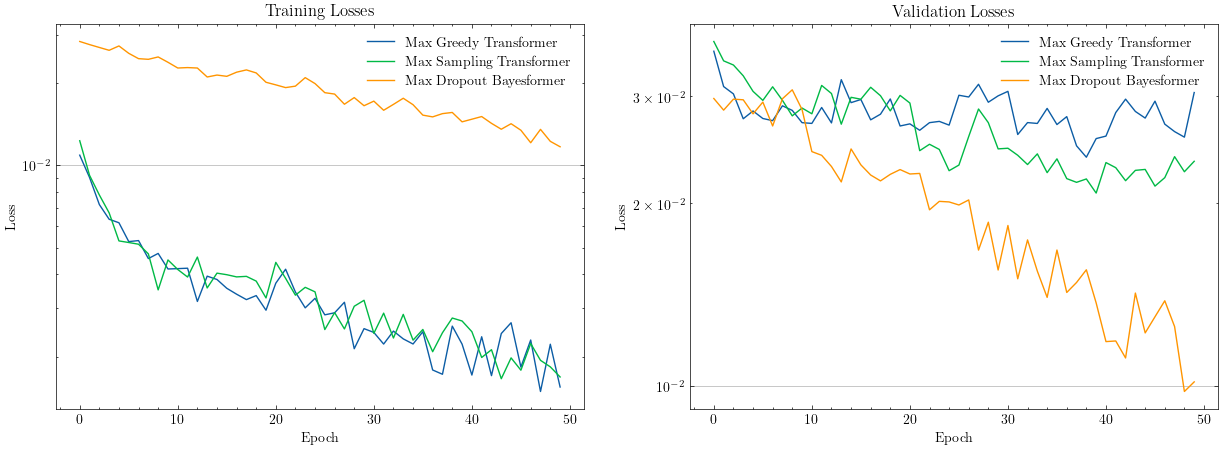

In [21]:
### PLOT : COMPARE LOSSES

visualization.plot_comparison_losses(
    [
        max_greedy_train_losses_transformer,
        max_sampling_train_losses_transformer,
        max_dropout_train_losses_bayesformer,
    ],
    [
        max_greedy_valid_losses_transformer,
        max_sampling_valid_losses_transformer,
        max_dropout_valid_losses_bayesformer,
    ],
    ["Max Greedy Transformer", "Max Sampling Transformer", "Max Dropout Bayesformer"],
    ylog=True,
)

### Active learning with margin uncertainty

In [22]:
margin_greedy_transformer = copy.deepcopy(transformer)
margin_sampling_transformer = copy.deepcopy(transformer)
margin_dropout_bayesformer = copy.deepcopy(bayesformer)

In [23]:
### ACTIVE LEARNING WITH MARGIN UNCERTAINTY : GREEDY TRANSFORMER

ids_margin_greedy_transformer = active_learning.select_samples(
    model=margin_greedy_transformer,
    tokenizer=tokenizer,
    pool_dataset=pool_dataset,
    device=DEVICE,
    nb_samples=200,
    compute="greedy",
    mode="margin",
)
margin_greedy_train_dataset = active_learning.create_new_train_set(
    train_dataset=train_dataset,
    pool_dataset=pool_dataset,
    indices=ids_margin_greedy_transformer,
)

margin_greedy_train_losses_transformer, margin_greedy_valid_losses_transformer = (
    utils.train(
        model=margin_greedy_transformer,
        train_dataset=margin_greedy_train_dataset,
        valid_dataset=valid_dataset,
        nb_epochs=AL_NB_EPOCHS,
        batch_size=AL_BATCH_SIZE,
        lr=AL_LEARNING_RATE,
        vocab_size=VOCAB_SIZE,
        tokenizer=tokenizer,
        device=DEVICE,
    )
)

EPOCH [5 / 50] ----------- TRAIN LOSS : 0.0060, VALID LOSS : 0.028824
EPOCH [10 / 50] ----------- TRAIN LOSS : 0.0041, VALID LOSS : 0.028575
EPOCH [15 / 50] ----------- TRAIN LOSS : 0.0038, VALID LOSS : 0.031237
EPOCH [20 / 50] ----------- TRAIN LOSS : 0.0038, VALID LOSS : 0.028054
EPOCH [25 / 50] ----------- TRAIN LOSS : 0.0029, VALID LOSS : 0.029662
EPOCH [30 / 50] ----------- TRAIN LOSS : 0.0022, VALID LOSS : 0.027212
EPOCH [35 / 50] ----------- TRAIN LOSS : 0.0022, VALID LOSS : 0.027511
EPOCH [40 / 50] ----------- TRAIN LOSS : 0.0025, VALID LOSS : 0.031116
EPOCH [45 / 50] ----------- TRAIN LOSS : 0.0020, VALID LOSS : 0.028604
EPOCH [50 / 50] ----------- TRAIN LOSS : 0.0020, VALID LOSS : 0.026205
Best valid loss : 0.0240


In [24]:
### ACTIVE LEARNING WITH MARGIN UNCERTAINTY : SAMPLING TRANSFORMER

ids_margin_sampling_transformer = active_learning.select_samples(
    model=margin_sampling_transformer,
    tokenizer=tokenizer,
    pool_dataset=pool_dataset,
    device=DEVICE,
    nb_samples=200,
    compute="sampling",
    mode="margin",
)
margin_sampling_train_dataset = active_learning.create_new_train_set(
    train_dataset=train_dataset,
    pool_dataset=pool_dataset,
    indices=ids_margin_sampling_transformer,
)

margin_sampling_train_losses_transformer, margin_sampling_valid_losses_transformer = (
    utils.train(
        model=margin_sampling_transformer,
        train_dataset=margin_sampling_train_dataset,
        valid_dataset=valid_dataset,
        nb_epochs=AL_NB_EPOCHS,
        batch_size=AL_BATCH_SIZE,
        lr=AL_LEARNING_RATE,
        vocab_size=VOCAB_SIZE,
        tokenizer=tokenizer,
        device=DEVICE,
    )
)

EPOCH [5 / 50] ----------- TRAIN LOSS : 0.0054, VALID LOSS : 0.030339
EPOCH [10 / 50] ----------- TRAIN LOSS : 0.0044, VALID LOSS : 0.028759
EPOCH [15 / 50] ----------- TRAIN LOSS : 0.0038, VALID LOSS : 0.026056
EPOCH [20 / 50] ----------- TRAIN LOSS : 0.0036, VALID LOSS : 0.026415
EPOCH [25 / 50] ----------- TRAIN LOSS : 0.0032, VALID LOSS : 0.026151
EPOCH [30 / 50] ----------- TRAIN LOSS : 0.0025, VALID LOSS : 0.026621
EPOCH [35 / 50] ----------- TRAIN LOSS : 0.0023, VALID LOSS : 0.024350
EPOCH [40 / 50] ----------- TRAIN LOSS : 0.0027, VALID LOSS : 0.025134
EPOCH [45 / 50] ----------- TRAIN LOSS : 0.0020, VALID LOSS : 0.021655
EPOCH [50 / 50] ----------- TRAIN LOSS : 0.0018, VALID LOSS : 0.021662
Best valid loss : 0.0209


In [25]:
### ACTIVE LEARNING WITH MARGIN UNCERTAINTY : DROPOUT BAYESFORMER

ids_margin_dropout_bayesformer = active_learning.select_samples(
    model=margin_dropout_bayesformer,
    tokenizer=tokenizer,
    pool_dataset=pool_dataset,
    device=DEVICE,
    nb_samples=200,
    compute="dropout",
    mode="margin",
)
margin_dropout_train_dataset = active_learning.create_new_train_set(
    train_dataset=train_dataset,
    pool_dataset=pool_dataset,
    indices=ids_margin_dropout_bayesformer,
)

margin_dropout_train_losses_bayesformer, margin_dropout_valid_losses_bayesformer = (
    utils.train(
        model=margin_dropout_bayesformer,
        train_dataset=margin_dropout_train_dataset,
        valid_dataset=valid_dataset,
        nb_epochs=AL_NB_EPOCHS,
        batch_size=AL_BATCH_SIZE,
        lr=AL_LEARNING_RATE,
        vocab_size=VOCAB_SIZE,
        tokenizer=tokenizer,
        device=DEVICE,
    )
)

EPOCH [5 / 50] ----------- TRAIN LOSS : 0.0247, VALID LOSS : 0.027886
EPOCH [10 / 50] ----------- TRAIN LOSS : 0.0239, VALID LOSS : 0.025292
EPOCH [15 / 50] ----------- TRAIN LOSS : 0.0224, VALID LOSS : 0.021251
EPOCH [20 / 50] ----------- TRAIN LOSS : 0.0198, VALID LOSS : 0.019593
EPOCH [25 / 50] ----------- TRAIN LOSS : 0.0189, VALID LOSS : 0.016002
EPOCH [30 / 50] ----------- TRAIN LOSS : 0.0162, VALID LOSS : 0.016521
EPOCH [35 / 50] ----------- TRAIN LOSS : 0.0152, VALID LOSS : 0.013433
EPOCH [40 / 50] ----------- TRAIN LOSS : 0.0132, VALID LOSS : 0.012887
EPOCH [45 / 50] ----------- TRAIN LOSS : 0.0132, VALID LOSS : 0.011203
EPOCH [50 / 50] ----------- TRAIN LOSS : 0.0129, VALID LOSS : 0.012023
Best valid loss : 0.0105


In [26]:
### ACCURACIES ON TEST SET

accuracy_test_margin_greedy_transformer = utils.evaluate(
    model=margin_greedy_transformer,
    dataset=test_dataset,
    tokenizer=tokenizer,
    batch_size=BATCH_SIZE,
    device=DEVICE,
)
accuracy_test_margin_sampling_transformer = utils.evaluate(
    model=margin_sampling_transformer,
    dataset=test_dataset,
    tokenizer=tokenizer,
    batch_size=BATCH_SIZE,
    device=DEVICE,
)
accuracy_test_margin_dropout_bayesformer = utils.evaluate(
    model=margin_dropout_bayesformer,
    dataset=test_dataset,
    tokenizer=tokenizer,
    batch_size=BATCH_SIZE,
    device=DEVICE,
)
print(
    f"Margin Greedy Transformer accuracy on test set: {accuracy_test_margin_greedy_transformer:.2f}"
)
print(
    f"Margin Sampling Transformer accuracy on test set: {accuracy_test_margin_sampling_transformer:.2f}"
)
print(
    f"Margin Dropout Bayesformer accuracy on test set: {accuracy_test_margin_dropout_bayesformer:.2f}"
)

Margin Greedy Transformer accuracy on test set: 0.54
Margin Sampling Transformer accuracy on test set: 0.56
Margin Dropout Bayesformer accuracy on test set: 0.62


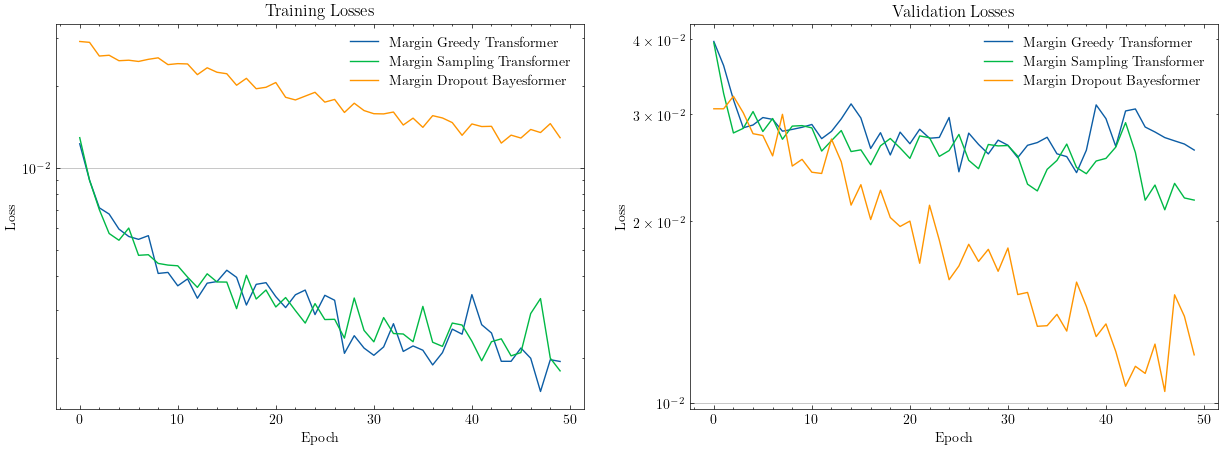

In [27]:
### PLOT : COMPARE LOSSES

visualization.plot_comparison_losses(
    [
        margin_greedy_train_losses_transformer,
        margin_sampling_train_losses_transformer,
        margin_dropout_train_losses_bayesformer,
    ],
    [
        margin_greedy_valid_losses_transformer,
        margin_sampling_valid_losses_transformer,
        margin_dropout_valid_losses_bayesformer,
    ],
    [
        "Margin Greedy Transformer",
        "Margin Sampling Transformer",
        "Margin Dropout Bayesformer",
    ],
    ylog=True,
)

### Active learning with entropy uncertainty

In [28]:
entropy_greedy_transformer = copy.deepcopy(transformer)
entropy_sampling_transformer = copy.deepcopy(transformer)
entropy_dropout_bayesformer = copy.deepcopy(bayesformer)

In [29]:
### ACTIVE LEARNING WITH ENTROPY UNCERTAINTY : GREEDY TRANSFORMER

ids_entropy_greedy_transformer = active_learning.select_samples(
    model=entropy_greedy_transformer,
    tokenizer=tokenizer,
    pool_dataset=pool_dataset,
    device=DEVICE,
    nb_samples=200,
    compute="greedy",
    mode="entropy",
)
entropy_greedy_train_dataset = active_learning.create_new_train_set(
    train_dataset=train_dataset,
    pool_dataset=pool_dataset,
    indices=ids_entropy_greedy_transformer,
)

entropy_greedy_train_losses_transformer, entropy_greedy_valid_losses_transformer = (
    utils.train(
        model=entropy_greedy_transformer,
        train_dataset=entropy_greedy_train_dataset,
        valid_dataset=valid_dataset,
        nb_epochs=AL_NB_EPOCHS,
        batch_size=AL_BATCH_SIZE,
        lr=AL_LEARNING_RATE,
        vocab_size=VOCAB_SIZE,
        tokenizer=tokenizer,
        device=DEVICE,
    )
)

EPOCH [5 / 50] ----------- TRAIN LOSS : 0.0083, VALID LOSS : 0.021758
EPOCH [10 / 50] ----------- TRAIN LOSS : 0.0057, VALID LOSS : 0.017497
EPOCH [15 / 50] ----------- TRAIN LOSS : 0.0058, VALID LOSS : 0.018323
EPOCH [20 / 50] ----------- TRAIN LOSS : 0.0040, VALID LOSS : 0.018647
EPOCH [25 / 50] ----------- TRAIN LOSS : 0.0034, VALID LOSS : 0.022816
EPOCH [30 / 50] ----------- TRAIN LOSS : 0.0036, VALID LOSS : 0.015993
EPOCH [35 / 50] ----------- TRAIN LOSS : 0.0027, VALID LOSS : 0.017082
EPOCH [40 / 50] ----------- TRAIN LOSS : 0.0028, VALID LOSS : 0.013749
EPOCH [45 / 50] ----------- TRAIN LOSS : 0.0028, VALID LOSS : 0.015791
EPOCH [50 / 50] ----------- TRAIN LOSS : 0.0018, VALID LOSS : 0.014906
Best valid loss : 0.0132


In [30]:
### ACTIVE LEARNING WITH ENTROPY UNCERTAINTY : SAMPLING TRANSFORMER

ids_entropy_sampling_transformer = active_learning.select_samples(
    model=entropy_sampling_transformer,
    tokenizer=tokenizer,
    pool_dataset=pool_dataset,
    device=DEVICE,
    nb_samples=200,
    compute="sampling",
    mode="entropy",
)
entropy_sampling_train_dataset = active_learning.create_new_train_set(
    train_dataset=train_dataset,
    pool_dataset=pool_dataset,
    indices=ids_entropy_sampling_transformer,
)

entropy_sampling_train_losses_transformer, entropy_sampling_valid_losses_transformer = (
    utils.train(
        model=entropy_sampling_transformer,
        train_dataset=entropy_sampling_train_dataset,
        valid_dataset=valid_dataset,
        nb_epochs=AL_NB_EPOCHS,
        batch_size=AL_BATCH_SIZE,
        lr=AL_LEARNING_RATE,
        vocab_size=VOCAB_SIZE,
        tokenizer=tokenizer,
        device=DEVICE,
    )
)

EPOCH [5 / 50] ----------- TRAIN LOSS : 0.0074, VALID LOSS : 0.022638
EPOCH [10 / 50] ----------- TRAIN LOSS : 0.0058, VALID LOSS : 0.020804
EPOCH [15 / 50] ----------- TRAIN LOSS : 0.0049, VALID LOSS : 0.018700
EPOCH [20 / 50] ----------- TRAIN LOSS : 0.0040, VALID LOSS : 0.017195
EPOCH [25 / 50] ----------- TRAIN LOSS : 0.0045, VALID LOSS : 0.017091
EPOCH [30 / 50] ----------- TRAIN LOSS : 0.0032, VALID LOSS : 0.016280
EPOCH [35 / 50] ----------- TRAIN LOSS : 0.0025, VALID LOSS : 0.014488
EPOCH [40 / 50] ----------- TRAIN LOSS : 0.0031, VALID LOSS : 0.016045
EPOCH [45 / 50] ----------- TRAIN LOSS : 0.0028, VALID LOSS : 0.014211
EPOCH [50 / 50] ----------- TRAIN LOSS : 0.0026, VALID LOSS : 0.012708
Best valid loss : 0.0127


In [31]:
### ACTIVE LEARNING WITH ENTROPY UNCERTAINTY : DROPOUT BAYESFORMER

ids_entropy_dropout_bayesformer = active_learning.select_samples(
    model=entropy_dropout_bayesformer,
    tokenizer=tokenizer,
    pool_dataset=pool_dataset,
    device=DEVICE,
    nb_samples=200,
    compute="dropout",
    mode="entropy",
)
entropy_dropout_train_dataset = active_learning.create_new_train_set(
    train_dataset=train_dataset,
    pool_dataset=pool_dataset,
    indices=ids_entropy_dropout_bayesformer,
)

entropy_dropout_train_losses_bayesformer, entropy_dropout_valid_losses_bayesformer = (
    utils.train(
        model=entropy_dropout_bayesformer,
        train_dataset=entropy_dropout_train_dataset,
        valid_dataset=valid_dataset,
        nb_epochs=AL_NB_EPOCHS,
        batch_size=AL_BATCH_SIZE,
        lr=AL_LEARNING_RATE,
        vocab_size=VOCAB_SIZE,
        tokenizer=tokenizer,
        device=DEVICE,
    )
)

EPOCH [5 / 50] ----------- TRAIN LOSS : 0.0292, VALID LOSS : 0.027651
EPOCH [10 / 50] ----------- TRAIN LOSS : 0.0256, VALID LOSS : 0.022241
EPOCH [15 / 50] ----------- TRAIN LOSS : 0.0236, VALID LOSS : 0.023202
EPOCH [20 / 50] ----------- TRAIN LOSS : 0.0197, VALID LOSS : 0.015629
EPOCH [25 / 50] ----------- TRAIN LOSS : 0.0186, VALID LOSS : 0.018288
EPOCH [30 / 50] ----------- TRAIN LOSS : 0.0175, VALID LOSS : 0.014490
EPOCH [35 / 50] ----------- TRAIN LOSS : 0.0150, VALID LOSS : 0.010654
EPOCH [40 / 50] ----------- TRAIN LOSS : 0.0147, VALID LOSS : 0.009632
EPOCH [45 / 50] ----------- TRAIN LOSS : 0.0110, VALID LOSS : 0.011716
EPOCH [50 / 50] ----------- TRAIN LOSS : 0.0125, VALID LOSS : 0.011385
Best valid loss : 0.0073


In [32]:
### ACCURACIES ON TEST SET

accuracy_test_entropy_greedy_transformer = utils.evaluate(
    model=entropy_greedy_transformer,
    dataset=test_dataset,
    tokenizer=tokenizer,
    batch_size=BATCH_SIZE,
    device=DEVICE,
)
accuracy_test_entropy_sampling_transformer = utils.evaluate(
    model=entropy_sampling_transformer,
    dataset=test_dataset,
    tokenizer=tokenizer,
    batch_size=BATCH_SIZE,
    device=DEVICE,
)
accuracy_test_entropy_dropout_bayesformer = utils.evaluate(
    model=entropy_dropout_bayesformer,
    dataset=test_dataset,
    tokenizer=tokenizer,
    batch_size=BATCH_SIZE,
    device=DEVICE,
)
print(
    f"Entropy Greedy Transformer accuracy on test set: {accuracy_test_entropy_greedy_transformer:.2f}"
)
print(
    f"Entropy Sampling Transformer accuracy on test set: {accuracy_test_entropy_sampling_transformer:.2f}"
)
print(
    f"Entropy Dropout Bayesformer accuracy on test set: {accuracy_test_entropy_dropout_bayesformer:.2f}"
)

Entropy Greedy Transformer accuracy on test set: 0.68
Entropy Sampling Transformer accuracy on test set: 0.70
Entropy Dropout Bayesformer accuracy on test set: 0.72


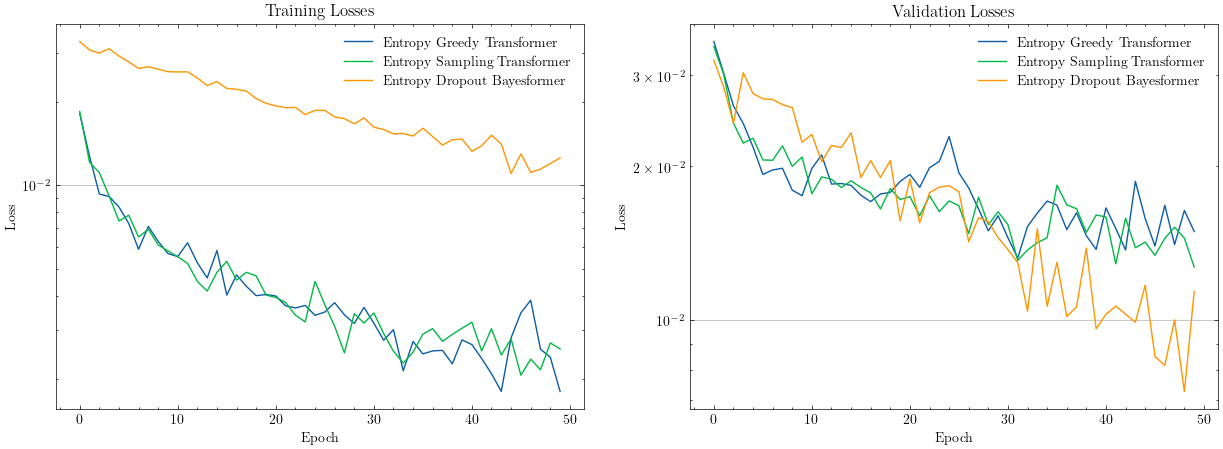

In [33]:
### PLOT : COMPARE LOSSES

visualization.plot_comparison_losses(
    [
        entropy_greedy_train_losses_transformer,
        entropy_sampling_train_losses_transformer,
        entropy_dropout_train_losses_bayesformer,
    ],
    [
        entropy_greedy_valid_losses_transformer,
        entropy_sampling_valid_losses_transformer,
        entropy_dropout_valid_losses_bayesformer,
    ],
    [
        "Entropy Greedy Transformer",
        "Entropy Sampling Transformer",
        "Entropy Dropout Bayesformer",
    ],
    ylog=True,
)

### Active learning : uncertainty method comparison for each model

**GREEDY TRANSFORMER**

In [34]:
### ACCURACIES ON TEST SET

print(
    f"Max Greedy Transformer accuracy on test set: {accuracy_test_max_greedy_transformer:.2f}"
)
print(
    f"Margin Greedy Transformer accuracy on test set: {accuracy_test_margin_greedy_transformer:.2f}"
)
print(
    f"Entropy Greedy Transformer accuracy on test set: {accuracy_test_entropy_greedy_transformer:.2f}"
)

Max Greedy Transformer accuracy on test set: 0.54
Margin Greedy Transformer accuracy on test set: 0.54
Entropy Greedy Transformer accuracy on test set: 0.68


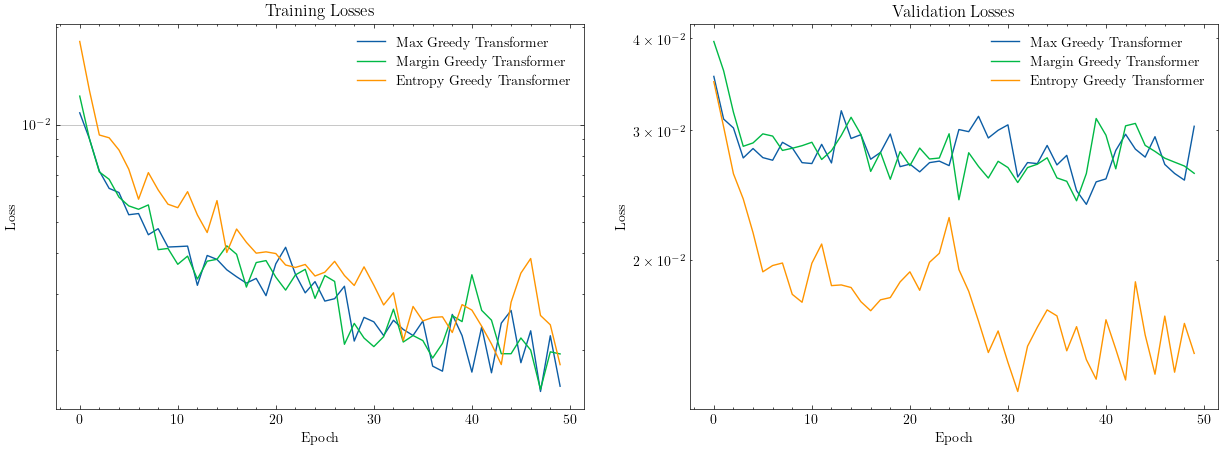

In [35]:
### PLOT : COMPARE LOSSES

visualization.plot_comparison_losses(
    [
        max_greedy_train_losses_transformer,
        margin_greedy_train_losses_transformer,
        entropy_greedy_train_losses_transformer,
    ],
    [
        max_greedy_valid_losses_transformer,
        margin_greedy_valid_losses_transformer,
        entropy_greedy_valid_losses_transformer,
    ],
    [
        "Max Greedy Transformer",
        "Margin Greedy Transformer",
        "Entropy Greedy Transformer",
    ],
    ylog=True,
)

**SAMPLING TRANSFORMER**

In [36]:
### ACCURACIES ON TEST SET

print(
    f"Max Sampling Transformer accuracy on test set: {accuracy_test_max_sampling_transformer:.2f}"
)
print(
    f"Margin Sampling Transformer accuracy on test set: {accuracy_test_margin_sampling_transformer:.2f}"
)
print(
    f"Entropy Sampling Transformer accuracy on test set: {accuracy_test_entropy_sampling_transformer:.2f}"
)

Max Sampling Transformer accuracy on test set: 0.56
Margin Sampling Transformer accuracy on test set: 0.56
Entropy Sampling Transformer accuracy on test set: 0.70


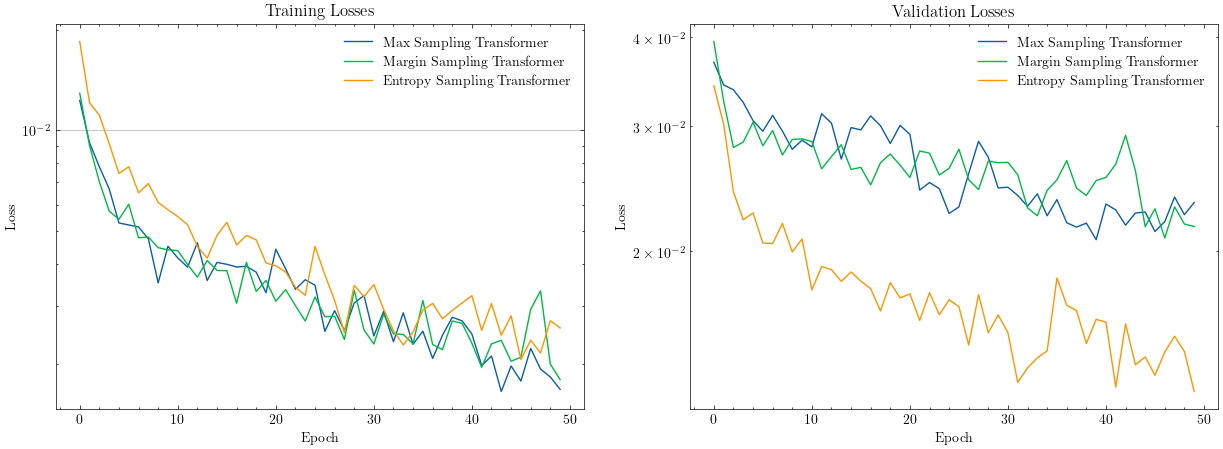

In [37]:
### PLOT : COMPARE LOSSES

visualization.plot_comparison_losses(
    [
        max_sampling_train_losses_transformer,
        margin_sampling_train_losses_transformer,
        entropy_sampling_train_losses_transformer,
    ],
    [
        max_sampling_valid_losses_transformer,
        margin_sampling_valid_losses_transformer,
        entropy_sampling_valid_losses_transformer,
    ],
    [
        "Max Sampling Transformer",
        "Margin Sampling Transformer",
        "Entropy Sampling Transformer",
    ],
    ylog=True,
)

**DROPOUT BAYESFORMER**

In [38]:
### ACCURACIES ON TEST SET

print(
    f"Max Dropout Bayesformer accuracy on test set: {accuracy_test_max_dropout_bayesformer:.2f}"
)
print(
    f"Margin Dropout Bayesformer accuracy on test set: {accuracy_test_margin_dropout_bayesformer:.2f}"
)
print(
    f"Entropy Dropout Bayesformer accuracy on test set: {accuracy_test_entropy_dropout_bayesformer:.2f}"
)

Max Dropout Bayesformer accuracy on test set: 0.64
Margin Dropout Bayesformer accuracy on test set: 0.62
Entropy Dropout Bayesformer accuracy on test set: 0.72


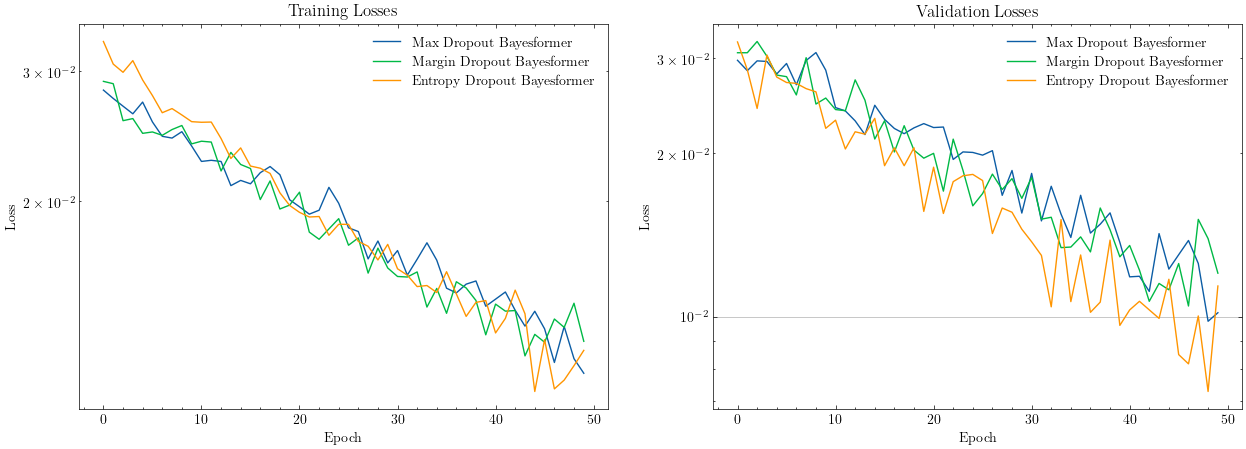

In [39]:
### PLOT : COMPARE LOSSES

visualization.plot_comparison_losses(
    [
        max_dropout_train_losses_bayesformer,
        margin_dropout_train_losses_bayesformer,
        entropy_dropout_train_losses_bayesformer,
    ],
    [
        max_dropout_valid_losses_bayesformer,
        margin_dropout_valid_losses_bayesformer,
        entropy_dropout_valid_losses_bayesformer,
    ],
    [
        "Max Dropout Bayesformer",
        "Margin Dropout Bayesformer",
        "Entropy Dropout Bayesformer",
    ],
    ylog=True,
)